# Uncertainty in AI — Explained via This Implementation

## What we mean by “uncertainty”

When a classifier outputs probabilities, we want to know **how sure** it is. In this project we separate that “unsureness” into two parts:

* **Aleatoric uncertainty** (data noise): ambiguity intrinsic to the input (e.g., a blurry digit). More data won’t fix it.
* **Epistemic uncertainty** (model uncertainty): doubt due to limited knowledge of the parameters or training data coverage. More/better data (or a richer model) can reduce it.

Your script estimates **total**, **aleatoric**, and **epistemic** uncertainty end-to-end and shows how they behave under normal conditions, calibration checks, selective prediction, and adversarial perturbations.

---

## The model & data

* **Dataset**: MNIST with standard normalization.
* **Model**: A small CNN (`SimpleNet`) with a **dropout layer** before the fully connected head. Dropout is crucial here because we use it two ways:

  1. as regularization during training;
  2. as a Bayesian approximation during inference (MC-Dropout).

---

## Two practical Bayesian approximations

### 1) MC-Dropout (stochastic test-time forward passes)

* At test time, the model is intentionally kept in **train mode** to **activate dropout**.
* You run **T** stochastic forward passes and collect **T** probability vectors per input.
* Intuition: each pass samples a plausible “version” of the network; the **spread** of predictions reflects **epistemic uncertainty**.

### 2) Deep Ensembles (different initializations)

* Train **K** independent copies of the same architecture with different random seeds.
* Each model produces probabilities; stacking them approximates multiple modes of the loss landscape.
* Intuition: ensembles capture diverse explanations of the data and tend to provide **stronger uncertainty signals** and better calibration.

---

## How the script quantifies uncertainty

Given a stack of predictive probabilities per input (from MC-Dropout or from the ensemble), the code computes:

* **Mean prediction**: the average probability over samples/models — this is what you’d typically **use to decide the class**.
* **Predictive entropy** *(total uncertainty)*: entropy of the **mean** prediction. High when the averaged distribution is flat.
* **Expected entropy** *(aleatoric)*: the **average** of entropies computed **inside** each sample/model, then averaged. High when **every** sampled model individually finds the input ambiguous.
* **Mutual information (MI)** *(epistemic)*: `predictive entropy − expected entropy`. High MI means **models disagree** with each other (knowledge uncertainty).

Additionally:

* **Confidence**: `max class probability` from the mean prediction — a simple inverse proxy for uncertainty.

---

## Calibration (Are probabilities trustworthy?)

The script computes **Expected Calibration Error (ECE)** and plots a **reliability diagram**:

* **ECE** bins predictions by confidence and compares **bin accuracy** to **bin confidence** (perfect is near 0).
* The **reliability plot** puts ideal calibration on the diagonal; points below the line indicate **overconfidence**.

MC-Dropout and (especially) **ensembles** typically reduce overconfidence (hence lower ECE) without retraining your backbone architecture.

---

## Selective prediction (abstain on uncertain cases)

A practical policy is to **skip predictions** above an uncertainty threshold:

* The code sweeps a threshold over **entropy** and reports **accuracy vs coverage** (what fraction you keep).
* You should see **accuracy rise** as coverage drops — showing the value of uncertainty for **risk-aware deployment** (e.g., “ask a human when uncertain”).

---

## Robustness check with adversarial noise

Using Foolbox FGSM:

* The script perturbs inputs with increasing **ε** (as a **fraction of the data’s actual value range**, so it’s robust to preprocessing).
* It tracks **accuracy** and **predictive entropy** as ε grows.
* Expected behavior:

  * **Accuracy drops** with stronger attacks.
  * **Entropy rises** (the model becomes less sure), a desirable property for **failure awareness**.
  * If entropy didn’t increase, your model would be **confidently wrong** — a red flag for safety.

---

## What the visualizations tell you

* **Histograms** compare MC-Dropout vs **Ensemble** for:

  * Predictive Entropy (total)
  * Mutual Information (epistemic)
  * Expected Entropy (aleatoric)
  * Confidence
* **Example grids**: side-by-side **most-certain** vs **most-uncertain** images with predicted/true labels help you sanity-check what drives uncertainty (e.g., ambiguous strokes, low contrast, atypical shapes).

---

## When to prefer which method

* **MC-Dropout**: Easiest to retrofit; small computational cost (T passes). Good “first uncertainty module” for any PyTorch model with dropout.
* **Deep Ensembles**: Often **better calibrated** and more robust (diverse minima) but costs **K× training** and **K× storage**. Use when stakes are high or you can afford the extra compute.

---

## Takeaways for trustworthy AI

1. **Uncertainty is not one thing**: total = aleatoric + epistemic. Your code computes all three explicitly.
2. **Confidence ≠ calibration**: measure **ECE** and use **reliability diagrams**; consider post-hoc calibration if needed.
3. **Abstention improves reliability**: thresholding on entropy/MI can dramatically **boost accuracy** at controlled coverage.
4. **Adversarial awareness matters**: uncertainty should **increase** as inputs get corrupted; if not, investigate.
5. **Practical Bayesianism wins**: MC-Dropout and Ensembles give you most of the value of Bayesian inference with minimal code changes.

---

## How to read your outputs at a glance

* **Summary table**: Compare **mean entropy**, **mean MI**, **mean confidence**, and **ECE** for MC-Dropout vs Ensemble.
* **Reliability plot**: Are points near the diagonal? Which method is closer?
* **Coverage–accuracy**: How quickly does accuracy improve as you drop uncertain cases?
* **Attack curves**: Does entropy rise (and accuracy fall) smoothly with ε? That’s healthy behavior.

This gives you a complete, implementation-grounded narrative you can drop into your module notes or slides, tightly aligned with the exact computations and figures your script produces.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)



# Device selection: CUDA > MPS (Apple Silicon) > CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")


Using device: mps


In [2]:
#==============================================================================
# 1. DATA PREPARATION
#==============================================================================

def get_mnist_loaders(batch_size=128):
    """Load MNIST dataset with train/test splits."""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


In [3]:
#==============================================================================
# 2. MODEL DEFINITION
#==============================================================================

class SimpleNet(nn.Module):
    """Simple CNN with dropout for uncertainty estimation."""
    
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
#==============================================================================
# 3. TRAINING UTILITIES
#==============================================================================

def train_model(model, train_loader, epochs=3, lr=0.001):
    """Train a single model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}")
    
    return model

def evaluate_model(model, test_loader, enable_dropout=False):
    """Evaluate model and return predictions and targets."""
    if enable_dropout:
        model.train()  # Keep dropout active for MC-Dropout
    else:
        model.eval()
    
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            all_probs.append(probs.cpu())
            all_targets.append(target.cpu())
    
    return torch.cat(all_probs), torch.cat(all_targets)

In [5]:
#==============================================================================
# 4. UNCERTAINTY QUANTIFICATION METHODS
#==============================================================================

def mc_dropout_predict(model, test_loader, n_samples=20):
    """
    Monte Carlo Dropout: Run multiple stochastic forward passes.
    
    Returns:
        predictions: [n_samples, n_test_points, n_classes] tensor
    """
    model.train()  # Keep dropout active
    predictions = []
    
    for _ in range(n_samples):
        probs, _ = evaluate_model(model, test_loader, enable_dropout=True)
        predictions.append(probs)
    
    return torch.stack(predictions)

def train_ensemble(train_loader, n_models=5, epochs=3):
    """
    Train multiple models with different random initializations.
    
    Returns:
        List of trained models
    """
    models = []
    
    for i in range(n_models):
        print(f"\nTraining ensemble model {i+1}/{n_models}")
        torch.manual_seed(42 + i)  # Different seed for each model
        
        model = SimpleNet().to(device)
        model = train_model(model, train_loader, epochs=epochs)
        models.append(model)
    
    return models

def ensemble_predict(models, test_loader):
    """
    Get predictions from ensemble of models.
    
    Returns:
        predictions: [n_models, n_test_points, n_classes] tensor
    """
    predictions = []
    
    for model in models:
        probs, _ = evaluate_model(model, test_loader, enable_dropout=False)
        predictions.append(probs)
    
    return torch.stack(predictions)

In [6]:
#==============================================================================
# 5. UNCERTAINTY METRICS
#==============================================================================

def compute_uncertainty_metrics(predictions):
    """
    Compute various uncertainty metrics from prediction samples.
    
    Args:
        predictions: [n_samples, n_points, n_classes] tensor
    
    Returns:
        Dictionary of uncertainty metrics
    """
    # Mean prediction across samples
    mean_pred = predictions.mean(dim=0)
    
    # Predictive entropy (total uncertainty)
    entropy = -torch.sum(mean_pred * torch.log(mean_pred + 1e-8), dim=1)
    
    # Expected entropy (aleatoric uncertainty)
    individual_entropies = -torch.sum(predictions * torch.log(predictions + 1e-8), dim=2)
    expected_entropy = individual_entropies.mean(dim=0)
    
    # Mutual information (epistemic uncertainty)
    mutual_info = entropy - expected_entropy
    
    # Confidence (maximum probability)
    confidence = mean_pred.max(dim=1)[0]
    
    return {
        'entropy': entropy,
        'mutual_info': mutual_info,
        'expected_entropy': expected_entropy,
        'confidence': confidence,
        'mean_prediction': mean_pred
    }


In [7]:
#==============================================================================
# 6. CALIBRATION ASSESSMENT
#==============================================================================

def expected_calibration_error(probs, targets, n_bins=10):
    """
    Compute Expected Calibration Error (ECE).
    
    A well-calibrated model has ECE close to 0.
    """
    confidences = probs.max(dim=1)[0]
    predictions = probs.argmax(dim=1)
    accuracies = (predictions == targets).float()
    
    ece = 0
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    
    for i in range(n_bins):
        bin_lower, bin_upper = bin_boundaries[i], bin_boundaries[i+1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.float().mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece.item()

def plot_reliability_diagram(probs, targets, n_bins=10, title="Reliability Diagram"):
    """Plot reliability diagram to assess calibration."""
    confidences = probs.max(dim=1)[0]
    predictions = probs.argmax(dim=1)
    accuracies = (predictions == targets).float()
    
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bin_boundaries[:-1] + bin_boundaries[1:]) / 2
    
    bin_accuracies = []
    bin_confidences = []
    
    for i in range(n_bins):
        bin_lower, bin_upper = bin_boundaries[i], bin_boundaries[i+1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        
        if in_bin.sum() > 0:
            bin_accuracies.append(accuracies[in_bin].mean().item())
            bin_confidences.append(confidences[in_bin].mean().item())
        else:
            bin_accuracies.append(0)
            bin_confidences.append(bin_centers[i])
    
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')
    plt.scatter(bin_confidences, bin_accuracies, s=100, alpha=0.7, label='Model')
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [8]:
#==============================================================================
# 7. VISUALIZATION FUNCTIONS
#==============================================================================

def visualize_uncertainty_examples(test_loader, uncertainty_metrics, targets, n_examples=5):
    """Visualize examples with highest and lowest uncertainty."""
    
    # Get test images
    test_images = []
    for data, _ in test_loader:
        test_images.append(data)
    test_images = torch.cat(test_images)
    
    entropy = uncertainty_metrics['entropy']
    predictions = uncertainty_metrics['mean_prediction'].argmax(dim=1)
    
    # Get indices of highest and lowest entropy
    high_entropy_idx = entropy.topk(n_examples).indices
    low_entropy_idx = entropy.topk(n_examples, largest=False).indices
    
    fig, axes = plt.subplots(2, n_examples, figsize=(15, 6))
    fig.suptitle('Uncertainty Visualization: High vs Low Entropy Examples')
    
    # Plot high entropy (uncertain) examples
    for i, idx in enumerate(high_entropy_idx):
        axes[0, i].imshow(test_images[idx].squeeze(), cmap='gray')
        axes[0, i].set_title(f'High Unc.\nPred: {predictions[idx]}, True: {targets[idx]}\nEntropy: {entropy[idx]:.3f}')
        axes[0, i].axis('off')
    
    # Plot low entropy (certain) examples
    for i, idx in enumerate(low_entropy_idx):
        axes[1, i].imshow(test_images[idx].squeeze(), cmap='gray')
        axes[1, i].set_title(f'Low Unc.\nPred: {predictions[idx]}, True: {targets[idx]}\nEntropy: {entropy[idx]:.3f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()


In [29]:
def plot_uncertainty_histograms(metrics_mc, metrics_ensemble):
    """Plot histograms comparing uncertainty distributions."""
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle('Uncertainty Metrics Comparison: MC-Dropout vs Ensemble')
    
    # Predictive Entropy
    axes[0, 0].hist(metrics_mc['entropy'], alpha=0.7, bins=30, label='MC-Dropout', density=True)
    axes[0, 0].hist(metrics_ensemble['entropy'], alpha=0.7, bins=30, label='Ensemble', density=True)
    axes[0, 0].set_title('Predictive Entropy (Total Uncertainty)')
    axes[0, 0].set_xlabel('Entropy')
    axes[0, 0].legend()
    
    # Mutual Information
    axes[0, 1].hist(metrics_mc['mutual_info'], alpha=0.7, bins=30, label='MC-Dropout', density=True)
    axes[0, 1].hist(metrics_ensemble['mutual_info'], alpha=0.7, bins=30, label='Ensemble', density=True)
    axes[0, 1].set_title('Mutual Information (Epistemic Uncertainty)')
    axes[0, 1].set_xlabel('Mutual Information')
    axes[0, 1].legend()
    
    # Expected Entropy
    axes[1, 0].hist(metrics_mc['expected_entropy'], alpha=0.7, bins=30, label='MC-Dropout', density=True)
    axes[1, 0].hist(metrics_ensemble['expected_entropy'], alpha=0.7, bins=30, label='Ensemble', density=True)
    axes[1, 0].set_title('Expected Entropy (Aleatoric Uncertainty)')
    axes[1, 0].set_xlabel('Expected Entropy')
    axes[1, 0].legend()
    
    # Confidence
    axes[1, 1].hist(metrics_mc['confidence'], alpha=0.7, bins=30, label='MC-Dropout', density=True)
    axes[1, 1].hist(metrics_ensemble['confidence'], alpha=0.7, bins=30, label='Ensemble', density=True)
    axes[1, 1].set_title('Confidence')
    axes[1, 1].set_xlabel('Max Probability')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()


In [10]:
#==============================================================================
# 8. MAIN EXPERIMENT RUNNER
#==============================================================================

"""Main function to run the complete uncertainty analysis."""

print("=" * 60)
print("DAT945 - Uncertainty in AI Models")
print("=" * 60)

# 1. Load data
print("\n1. Loading MNIST dataset...")
train_loader, test_loader = get_mnist_loaders()




DAT945 - Uncertainty in AI Models

1. Loading MNIST dataset...


In [11]:
# 2. Train baseline model
print("\n2. Training baseline model...")
baseline_model = SimpleNet().to(device)
baseline_model = train_model(baseline_model, train_loader, epochs=3)

# Evaluate baseline
probs, targets = evaluate_model(baseline_model, test_loader)
accuracy = accuracy_score(targets, probs.argmax(dim=1))
print(f"Baseline accuracy: {accuracy:.3f}")




2. Training baseline model...
Epoch 1/3, Average Loss: 0.2023
Epoch 2/3, Average Loss: 0.0685
Epoch 3/3, Average Loss: 0.0521
Baseline accuracy: 0.990


In [12]:
# 3. MC-Dropout uncertainty
print("\n3. Computing MC-Dropout uncertainty...")
mc_predictions = mc_dropout_predict(baseline_model, test_loader, n_samples=20)
metrics_mc = compute_uncertainty_metrics(mc_predictions)


3. Computing MC-Dropout uncertainty...


In [13]:
# 4. Ensemble uncertainty
print("\n4. Training ensemble for uncertainty...")
ensemble_models = train_ensemble(train_loader, n_models=5, epochs=2)
ensemble_predictions = ensemble_predict(ensemble_models, test_loader)
metrics_ensemble = compute_uncertainty_metrics(ensemble_predictions)


4. Training ensemble for uncertainty...

Training ensemble model 1/5
Epoch 1/2, Average Loss: 0.2023
Epoch 2/2, Average Loss: 0.0685

Training ensemble model 2/5
Epoch 1/2, Average Loss: 0.1925
Epoch 2/2, Average Loss: 0.0667

Training ensemble model 3/5
Epoch 1/2, Average Loss: 0.2033
Epoch 2/2, Average Loss: 0.0661

Training ensemble model 4/5
Epoch 1/2, Average Loss: 0.1928
Epoch 2/2, Average Loss: 0.0661

Training ensemble model 5/5
Epoch 1/2, Average Loss: 0.2008
Epoch 2/2, Average Loss: 0.0685


In [14]:
# 5. Evaluate calibration
print("\n5. Evaluating calibration...")
ece_mc = expected_calibration_error(metrics_mc['mean_prediction'], targets)
ece_ensemble = expected_calibration_error(metrics_ensemble['mean_prediction'], targets)

print(f"MC-Dropout ECE: {ece_mc:.4f}")
print(f"Ensemble ECE: {ece_ensemble:.4f}")


5. Evaluating calibration...
MC-Dropout ECE: 0.0082
Ensemble ECE: 0.0076



6. Creating visualizations...


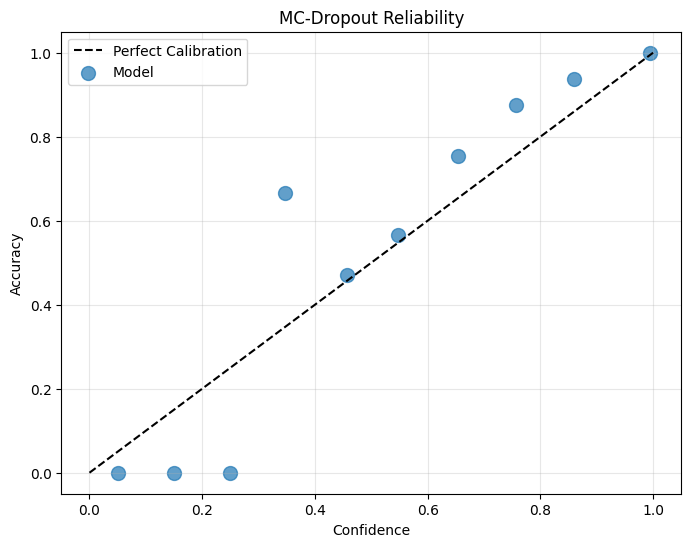

In [15]:
# 6. Visualizations
print("\n6. Creating visualizations...")

# Plot reliability diagrams
plot_reliability_diagram(metrics_mc['mean_prediction'], targets, 
                       title="MC-Dropout Reliability")


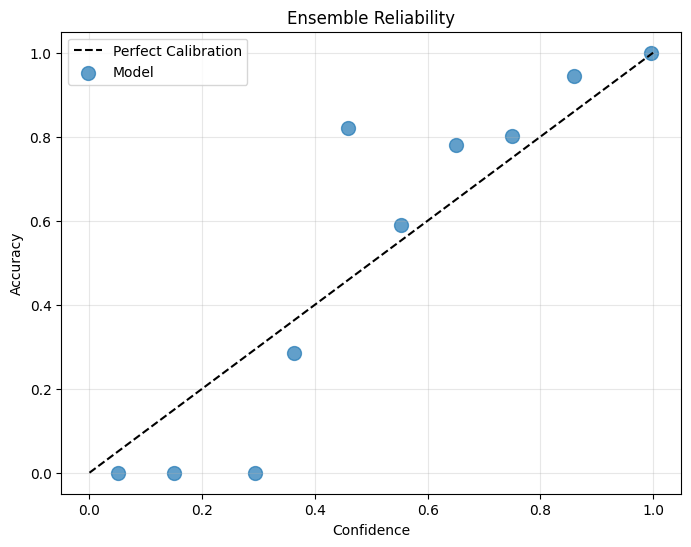

In [16]:
plot_reliability_diagram(metrics_ensemble['mean_prediction'], targets, 
                       title="Ensemble Reliability")


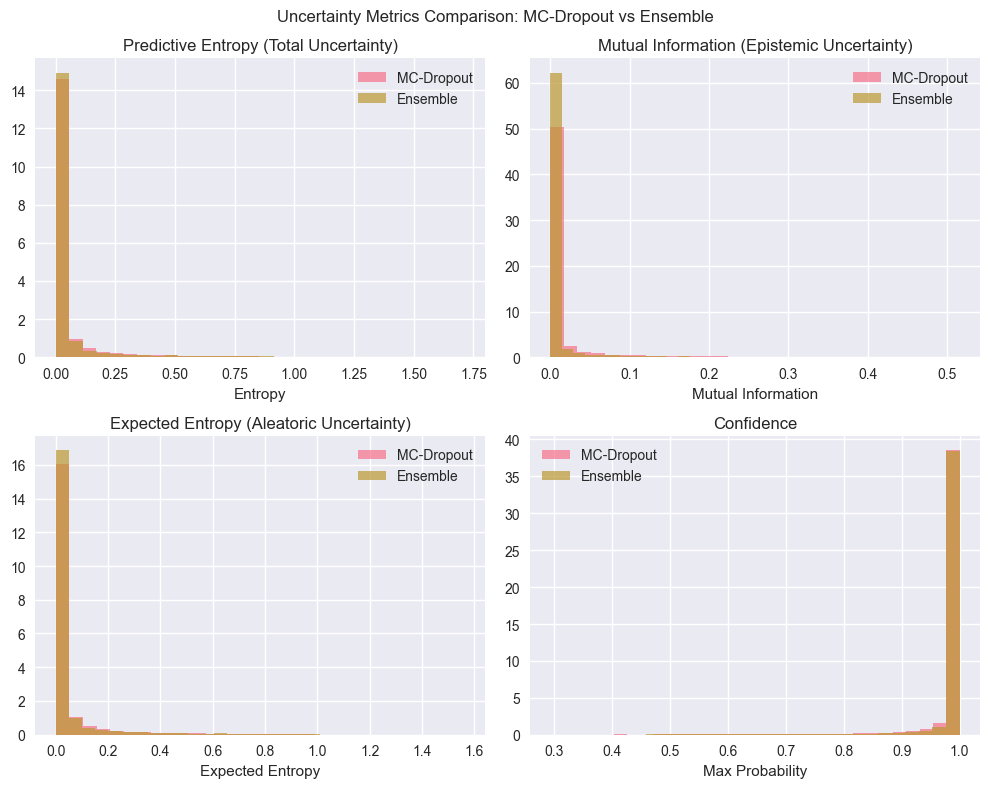

In [30]:
# Plot uncertainty comparisons
plot_uncertainty_histograms(metrics_mc, metrics_ensemble)

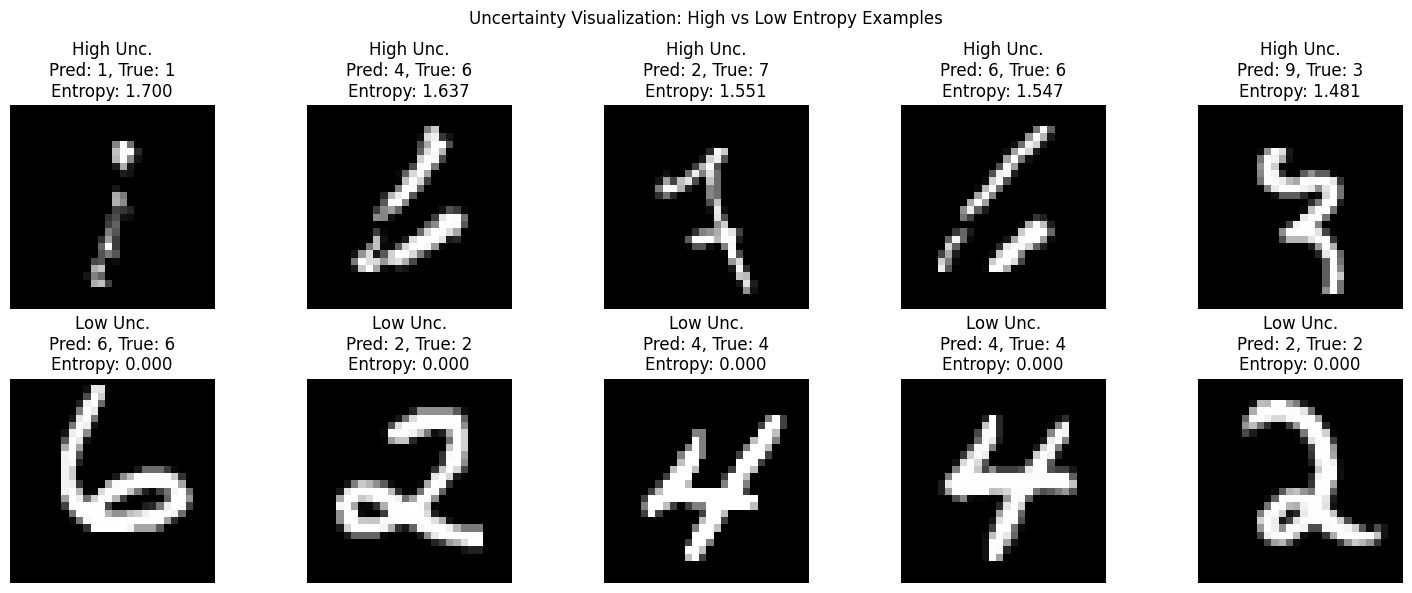

In [18]:
# Show examples
visualize_uncertainty_examples(test_loader, metrics_mc, targets)

In [19]:
# 7. Summary statistics
print("\n7. Summary Statistics:")
print("-" * 40)
print(f"{'Metric':<25} {'MC-Dropout':<12} {'Ensemble':<12}")
print("-" * 40)
print(f"{'Mean Entropy':<25} {metrics_mc['entropy'].mean():<12.4f} {metrics_ensemble['entropy'].mean():<12.4f}")
print(f"{'Mean Mutual Info':<25} {metrics_mc['mutual_info'].mean():<12.4f} {metrics_ensemble['mutual_info'].mean():<12.4f}")
print(f"{'Mean Confidence':<25} {metrics_mc['confidence'].mean():<12.4f} {metrics_ensemble['confidence'].mean():<12.4f}")
print(f"{'Calibration Error':<25} {ece_mc:<12.4f} {ece_ensemble:<12.4f}")
print("-" * 40)


7. Summary Statistics:
----------------------------------------
Metric                    MC-Dropout   Ensemble    
----------------------------------------
Mean Entropy              0.0599       0.0533      
Mean Mutual Info          0.0135       0.0080      
Mean Confidence           0.9817       0.9837      
Calibration Error         0.0082       0.0076      
----------------------------------------


In [20]:
metrics_mc

{'entropy': tensor([0.0004, 0.0002, 0.0057,  ..., 0.0003, 0.0191, 0.0020]),
 'mutual_info': tensor([2.4804e-05, 1.7492e-05, 4.5680e-04,  ..., 1.7506e-05, 2.3679e-03,
         1.6058e-04]),
 'expected_entropy': tensor([0.0004, 0.0002, 0.0052,  ..., 0.0003, 0.0167, 0.0018]),
 'confidence': tensor([1.0000, 1.0000, 0.9994,  ..., 1.0000, 0.9974, 0.9998]),
 'mean_prediction': tensor([[6.6797e-08, 8.9436e-08, 5.6790e-07,  ..., 9.9996e-01, 3.5186e-07,
          3.0075e-05],
         [1.9754e-06, 8.5310e-06, 9.9999e-01,  ..., 2.4223e-08, 2.7599e-06,
          3.5249e-09],
         [3.3696e-06, 9.9941e-01, 8.1963e-06,  ..., 1.0549e-04, 2.4992e-05,
          3.4002e-06],
         ...,
         [3.6918e-10, 1.2741e-07, 2.4714e-09,  ..., 5.3966e-07, 3.8156e-06,
          1.7933e-05],
         [9.2323e-06, 6.2429e-08, 6.3463e-08,  ..., 5.7329e-08, 2.4690e-03,
          3.0926e-06],
         [7.5603e-05, 1.7955e-08, 1.6881e-05,  ..., 3.3299e-10, 7.7175e-05,
          1.7758e-07]])}

In [21]:
metrics_ensemble

{'entropy': tensor([0.0002, 0.0009, 0.0057,  ..., 0.0004, 0.0106, 0.0008]),
 'mutual_info': tensor([9.3384e-06, 2.2970e-05, 2.9870e-04,  ..., 1.3753e-05, 4.9985e-04,
         2.8980e-05]),
 'expected_entropy': tensor([0.0002, 0.0009, 0.0054,  ..., 0.0003, 0.0101, 0.0008]),
 'confidence': tensor([1.0000, 0.9999, 0.9994,  ..., 1.0000, 0.9987, 0.9999]),
 'mean_prediction': tensor([[3.1710e-08, 1.4648e-07, 8.7400e-06,  ..., 9.9998e-01, 6.5496e-08,
          3.8122e-06],
         [1.2626e-06, 8.3443e-05, 9.9991e-01,  ..., 1.3211e-08, 1.1321e-06,
          2.3348e-10],
         [9.3848e-06, 9.9943e-01, 3.3589e-05,  ..., 1.5303e-04, 6.2355e-05,
          1.1639e-05],
         ...,
         [9.4693e-09, 1.6530e-06, 4.0010e-08,  ..., 6.2122e-06, 8.3941e-06,
          1.1095e-05],
         [2.1961e-06, 1.4705e-08, 9.8938e-08,  ..., 6.3894e-08, 1.2609e-03,
          1.3973e-06],
         [1.4711e-05, 4.9936e-08, 3.3753e-06,  ..., 1.6904e-09, 5.5624e-06,
          1.3833e-07]])}

In [22]:
baseline_model

SimpleNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
ensemble_models

[SimpleNet(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.5, inplace=False)
   (fc1): Linear(in_features=3136, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ),
 SimpleNet(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.5, inplace=False)
   (fc1): Linear(in_features=3136, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=10, bias=True)
 ),
 SimpleNet(
   (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1,


=== Running KDE on MNIST dataset ===


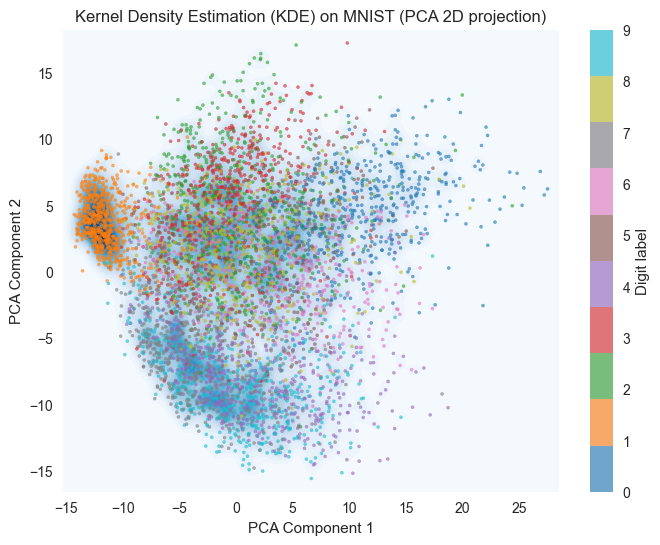

In [37]:
# ======================================================
# === Kernel Density Estimation (KDE) on MNIST Data ===
# ======================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity

print("\n=== Running KDE on MNIST dataset ===")

# Extract a subset of data from train_loader (flattened images + labels)
X_list, y_list = [], []
for batch_idx, (images, labels) in enumerate(test_loader):
    X_list.append(images.view(images.size(0), -1).numpy())  # flatten to vectors
    y_list.append(labels.numpy())
    if batch_idx * train_loader.batch_size > 5000:  # limit for speed
        break

X = np.vstack(X_list)
y = np.hstack(y_list)

# Reduce dimensionality with PCA (2D for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Fit KDE on PCA-reduced data
kde = KernelDensity(bandwidth=0.5, kernel="gaussian")
kde.fit(X_pca)

# Create a mesh grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Evaluate KDE
log_density = kde.score_samples(grid_points)
Z = np.exp(log_density).reshape(xx.shape)

# Plot KDE contours with data points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, cmap="Blues", levels=30)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=5, cmap="tab10", alpha=0.6)
plt.title("Kernel Density Estimation (KDE) on MNIST (PCA 2D projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Digit label")
plt.show()


In [36]:
metrics_mc['entropy'].shape

torch.Size([10000])

In [42]:
mc_predictions.shape

torch.Size([20, 10000, 10])

       threshold  accuracy  coverage
0   7.398671e-07  1.000000    0.0001
1   1.214421e-01  0.999887    0.8859
2   2.428834e-01  0.999784    0.9279
3   3.643247e-01  0.999369    0.9505
4   4.857661e-01  0.998547    0.9635
5   6.072074e-01  0.997841    0.9728
6   7.286487e-01  0.996029    0.9822
7   8.500900e-01  0.994235    0.9887
8   9.715314e-01  0.992645    0.9925
9   1.092973e+00  0.991562    0.9955
10  1.214414e+00  0.990479    0.9978
11  1.335855e+00  0.990389    0.9989
12  1.457297e+00  0.990195    0.9995
13  1.578738e+00  0.989998    0.9998
14  1.700179e+00  0.989900    1.0000


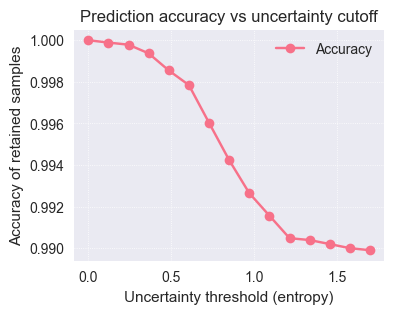

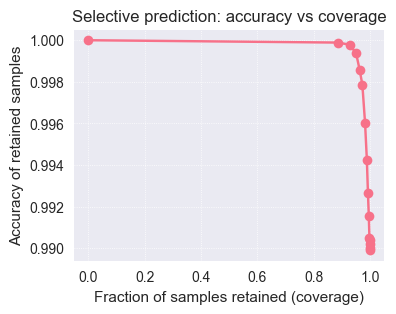

In [46]:
# =============================================================
# === Uncertainty-based Rejection Analysis ====================
# =============================================================
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score

# --- 1) Get ground-truth labels (aligned with mc_predictions) ---
targets_list = []
for _, labels in test_loader:
    targets_list.append(labels.numpy())
targets = np.hstack(targets_list)
assert targets.shape[0] == mc_predictions.shape[1], "Mismatch: targets vs mc_predictions samples."

# --- 2) Compute mean prediction across MC samples ---
probs_mean = mc_predictions.mean(dim=0).cpu().numpy()   # [n_samples, n_classes]
y_pred = probs_mean.argmax(axis=1)

# --- 3) Get uncertainty values (entropy) ---
uncertainty = np.asarray(metrics_mc['entropy'])  # shape [n_samples]

# --- 4) Define thresholds and evaluate accuracy ---
thresholds = np.linspace(uncertainty.min(), uncertainty.max(), 15)  # 15 cutoffs
results = []
for th in thresholds:
    mask = uncertainty <= th
    kept = mask.sum()
    if kept > 0:
        acc = accuracy_score(targets[mask], y_pred[mask])
    else:
        acc = np.nan
    results.append((th, acc, kept / len(targets)))

df_results = pd.DataFrame(results, columns=["threshold", "accuracy", "coverage"])
print(df_results)

# --- 5) Plot accuracy vs uncertainty threshold ---
plt.figure(figsize=(4,3))
plt.plot(df_results["threshold"], df_results["accuracy"], "o-", label="Accuracy")
plt.xlabel("Uncertainty threshold (entropy)")
plt.ylabel("Accuracy of retained samples")
plt.title("Prediction accuracy vs uncertainty cutoff")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.legend()
plt.show()

# --- 6) Plot accuracy vs coverage (fraction retained) ---
plt.figure(figsize=(4,3))
plt.plot(df_results["coverage"], df_results["accuracy"], "o-")
plt.xlabel("Fraction of samples retained (coverage)")
plt.ylabel("Accuracy of retained samples")
plt.title("Selective prediction: accuracy vs coverage")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.show()


[INFO] Detected input bounds from data: lower=-0.4242, upper=2.8215
[INFO] Epsilon mapping (relative -> absolute):
  ε_rel=0.000  ->  ε_abs=0.000000
  ε_rel=0.050  ->  ε_abs=0.162285
  ε_rel=0.100  ->  ε_abs=0.324570
  ε_rel=0.200  ->  ε_abs=0.649140
  ε_rel=0.300  ->  ε_abs=0.973710

=== Running attack → MC-Dropout uncertainty per epsilon ===


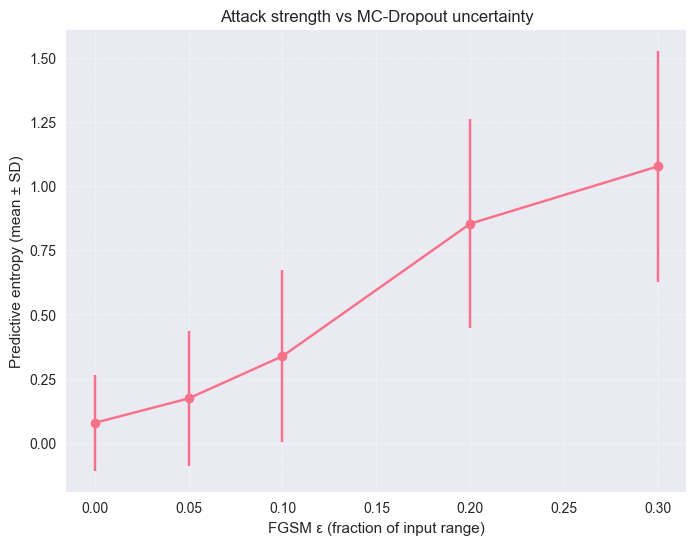

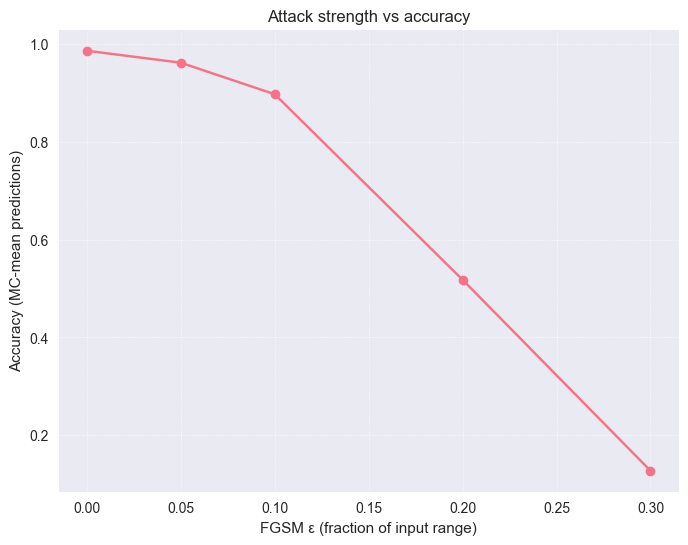

/var/folders/rh/1c0lrj_x0x956417g86lc4ph0000gn/T/ipykernel_81394/3001113518.py:117: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=[f"{e:.2f}" for e in eps_fracs], showfliers=False)


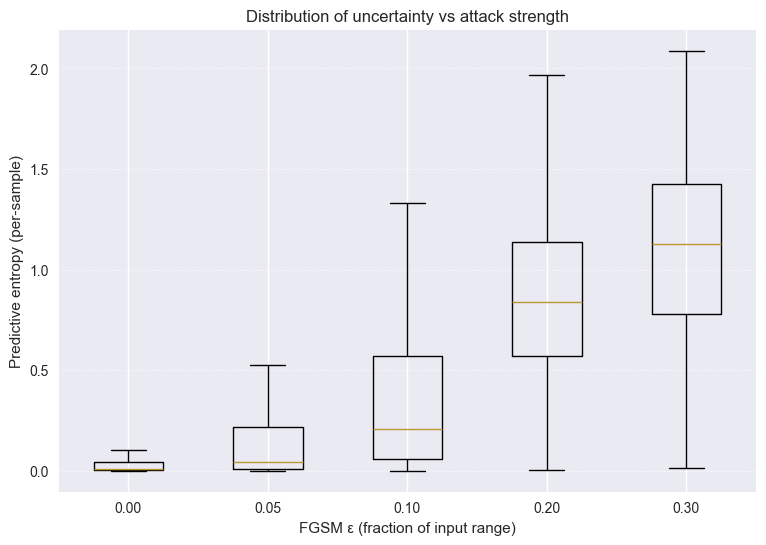

In [49]:
# =============================================================
# === Attacks vs Uncertainty (MC-Dropout on Adversarials) =====
# ====== Robust to any input normalization / bounds ===========#
# =============================================================
import numpy as np
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import foolbox as fb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = baseline_model.to(device).eval()

# 1) Fix a subset from the test set (whatever your transform is, we use it as-is)
N_SAMPLES = 2000
imgs, lbls = [], []
collected = 0
for x, y in test_loader:
    imgs.append(x)
    lbls.append(y)
    collected += x.size(0)
    if collected >= N_SAMPLES:
        break

x_test = torch.cat(imgs, dim=0)[:N_SAMPLES].to(device)   # (N, 1, 28, 28)
y_test = torch.cat(lbls, dim=0)[:N_SAMPLES].to(device)   # (N,)

# 2) Detect actual bounds from these tensors and wrap model for Foolbox
lower = float(x_test.min().item())
upper = float(x_test.max().item())
print(f"[INFO] Detected input bounds from data: lower={lower:.4f}, upper={upper:.4f}")
fmodel = fb.PyTorchModel(baseline_model, bounds=(lower, upper), device=device)

# 3) Choose epsilons as FRACTIONS of the input range (works for any normalization)
#    e.g., 0.2 here means perturb by 20% of (upper - lower) in your current input space.
eps_fracs = [0.00, 0.05, 0.10, 0.20, 0.30]  # tweak as you like
range_span = upper - lower
epsilons_abs = [frac * range_span for frac in eps_fracs]
print("[INFO] Epsilon mapping (relative -> absolute):")
for f, a in zip(eps_fracs, epsilons_abs):
    print(f"  ε_rel={f:.3f}  ->  ε_abs={a:.6f}")

attack = fb.attacks.LinfFastGradientAttack()

def make_loader(x_tensor, y_tensor, batch_size=None):
    if batch_size is None:
        batch_size = getattr(test_loader, "batch_size", 128)
    ds = data.TensorDataset(x_tensor.detach().cpu(), y_tensor.detach().cpu())
    return data.DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=False)

entropy_stats = []        # (eps_rel, mean_entropy, std_entropy)
acc_stats = []            # (eps_rel, accuracy)
per_eps_entropy = {}      # eps_rel -> per-sample entropy

print("\n=== Running attack → MC-Dropout uncertainty per epsilon ===")
for eps_rel, eps_abs in zip(eps_fracs, epsilons_abs):
    # Generate adversarials at absolute epsilon in current space
    advs, _, _ = attack(fmodel, x_test, y_test, epsilons=eps_abs)
    if advs.dim() == 5:   # safety if a list accidentally passed
        advs = advs[0]

    # MC-Dropout on adversarial set
    adv_loader = make_loader(advs, y_test)
    mc_predictions_adv = mc_dropout_predict(baseline_model, adv_loader, n_samples=20)  # [T, N, C]
    metrics_mc_adv = compute_uncertainty_metrics(mc_predictions_adv)

    # Uncertainty vector (prefer 'entropy')
    if "entropy" in metrics_mc_adv:
        ent_vec = np.asarray(metrics_mc_adv["entropy"]).reshape(-1)
    elif "predictive_entropy" in metrics_mc_adv:
        ent_vec = np.asarray(metrics_mc_adv["predictive_entropy"]).reshape(-1)
    else:
        probs_mean_fb = mc_predictions_adv.mean(dim=0).cpu().numpy()
        ent_vec = -(probs_mean_fb * np.log(np.clip(probs_mean_fb, 1e-12, 1.0))).sum(axis=1)

    per_eps_entropy[eps_rel] = ent_vec
    entropy_stats.append((eps_rel, float(ent_vec.mean()), float(ent_vec.std(ddof=0))))

    # Accuracy from MC-mean probs
    probs_mean = mc_predictions_adv.mean(dim=0).cpu().numpy()  # [N, C]
    y_pred = probs_mean.argmax(axis=1)
    acc = accuracy_score(y_test.cpu().numpy(), y_pred)
    acc_stats.append((eps_rel, acc))

# Prepare arrays
eps_rel_arr = np.array([e for e, _, _ in entropy_stats], dtype=float)
ent_mean = np.array([m for _, m, _ in entropy_stats], dtype=float)
ent_std  = np.array([s for _, _, s in entropy_stats], dtype=float)

acc_eps  = np.array([e for e, _ in acc_stats], dtype=float)
acc_val  = np.array([a for _, a in acc_stats], dtype=float)

# Plot: Uncertainty vs epsilon (relative)
plt.figure(figsize=(8,6))
plt.errorbar(eps_rel_arr, ent_mean, yerr=ent_std, fmt="o-", capsize=4)
plt.xlabel("FGSM ε (fraction of input range)")
plt.ylabel("Predictive entropy (mean ± SD)")
plt.title("Attack strength vs MC-Dropout uncertainty")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.show()

# Plot: Accuracy vs epsilon (relative)
plt.figure(figsize=(8,6))
plt.plot(acc_eps, acc_val, "o-")
plt.xlabel("FGSM ε (fraction of input range)")
plt.ylabel("Accuracy (MC-mean predictions)")
plt.title("Attack strength vs accuracy")
plt.grid(True, linestyle=":", linewidth=0.6)
plt.show()

# Optional: Boxplot of per-sample entropy by epsilon (relative)
try:
    data_box = [per_eps_entropy[e] for e in eps_fracs]
    plt.figure(figsize=(9,6))
    plt.boxplot(data_box, labels=[f"{e:.2f}" for e in eps_fracs], showfliers=False)
    plt.xlabel("FGSM ε (fraction of input range)")
    plt.ylabel("Predictive entropy (per-sample)")
    plt.title("Distribution of uncertainty vs attack strength")
    plt.grid(True, axis="y", linestyle=":", linewidth=0.6)
    plt.show()
except Exception:
    pass
